# **Stage 1**
### **Protein and ligand library selection, protein and ligand preparation**

**Choosing the protein**

For this project we have chosen the 5cno protein which can be downloaded at: <br>
https://www.rcsb.org/structure/5CNO <br>
The protein is saved in this repo as 5cno.pdb.
Using PyMOL we have removed solvent, removed organic and added hydrogens. 
The prepared 5cno is saved in this repo as 5cno_prepared.pdb. 

**Choosing the ligand library**

We have chosen the ligand library available for download at: <br>
https://enamine.net/compound-libraries/targeted-libraries/kinase-library <br>
The zipped ligand library is saved in this repo as Enamine_Kinase_Library_plated.zip.
Due to limitations of our personal hardware we have randomly chosen 10k ligands using the sampling.py script
and saved the output as sampled_ligands.sdf. <br>

**Importing necessary libraries**

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem.rdMolAlign import GetBestRMS
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
import random
import numpy as np
import json
from openbabel import pybel
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

**Getting the geometric centroid of docking box**

In [2]:
mol = Chem.MolFromPDBFile("5cno.pdb", removeHs=False)
residues = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)

ligand = min(residues, key=lambda x: x.GetNumAtoms())

import numpy as np

def get_centroid(mol):
    """Calculate the geometric center (centroid) of a molecule."""
    conf = mol.GetConformer()
    coords = np.array([conf.GetAtomPosition(i) for i in range(mol.GetNumAtoms())])
    return np.mean(coords, axis=0)

ligand_centroid = get_centroid(ligand)
print(f"Ligand centroid coordinates (x, y, z): {ligand_centroid}")

Ligand centroid coordinates (x, y, z): [-48.405 -37.514  19.017]


**Converting the protein file to .pdbqt for AutoDock Vina compatibility**

In [3]:
subprocess.run(["./convert_to_pdbqt.sh"], check=True)

Converting 5cno_prepared.pdb to 5cno_clean.pdbqt...
Successfully created 5cno_clean.pdbqt


1 molecule converted


CompletedProcess(args=['./convert_to_pdbqt.sh'], returncode=0)

Loading the sampled ligands and clustering them based on their tanimoto similarity. Then adding hydrogens to the sampled ligands. Charges will be added later, due to future format conversions.
We will perform docking on one representative of each cluster, again, due to technical limitations. We will later dock the members of the clusters of top performers.

In [ ]:
# loading and embedding ligands from the .sdf file
def load_3d_ligands(sdf_file):
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
    ligands = []
    for mol in suppl:
        if mol is None:
            continue
        mol = Chem.AddHs(mol)
        if AllChem.EmbedMolecule(mol, AllChem.ETKDG()) != 0:
            print("Embedding failed for a molecule, skipping...")
            continue
        AllChem.UFFOptimizeMolecule(mol)
        ligands.append(mol)
    return ligands

# Computing MACCS fingerprints
def get_fingerprints(mols):
    return [rdMolDescriptors.GetMACCSKeysFingerprint(mol) for mol in mols]

# Computing Tanimoto similarity matrix
def tanimoto_similarity(fp_list):
    size = len(fp_list)
    sim_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i + 1, size):
            sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
            sim_matrix[j, i] = sim_matrix[i, j]
    return sim_matrix

# Butina clusterisation
def cluster_ligands(fp_list, cutoff=0.5):
    dists = []
    size = len(fp_list)
    for i in range(1, size):
        for j in range(i):
            dists.append(1 - DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j]))
    clusters = Butina.ClusterData(dists, size, cutoff, isDistData=True)
    return clusters

# Main function
def process_ligands(sdf_file):
    mols = load_3d_ligands(sdf_file)
    fps = get_fingerprints(mols)
    clusters = cluster_ligands(fps)
    prepared_mols = add_charges(mols)
    return clusters, prepared_mols

sdf_file = "sampled_ligands.sdf"
clusters, prepared_ligands = process_ligands(sdf_file)


**Number of clusters:**

In [ ]:
len(clusters)

**Saving the clusters as clusters.json**

In [ ]:
def save_clusters_to_json(clusters, filename):
    # Convert tuple of tuples to list of lists for JSON serialization
    clusters_list = [list(cluster) for cluster in clusters]
    with open(filename, "w") as f:
        json.dump(clusters_list, f, indent=4)

save_clusters_to_json(clusters, "clusters.json")

# To load run:
# def load_clusters_from_json(filename):
#     with open(filename, "r") as f:
#         clusters_list = json.load(f)
#     # Convert each inner list back to a tuple (optional)a
#     clusters = tuple(tuple(cluster) for cluster in clusters_list)
#     return clusters

**Choosing a random ligand from each cluster**

In [ ]:
def get_random_ligands_from_clusters(clusters, all_ligands):
    random_ligands = []
    for cluster in clusters:
        # Select a random index from this cluster
        random_idx = random.choice(cluster)
        # Get the corresponding ligand
        random_ligands.append(all_ligands[random_idx])
    return random_ligands

random_ligands = get_random_ligands_from_clusters(clusters, prepared_ligands)

**Saving the drawn ligands into .pdbqt files for AutoDock Vina**

In [ ]:
def mol_to_pdbqt(mol, filename):
    if mol.GetNumConformers() == 0:
        raise ValueError(f"Molecule has no conformers: {filename}")
    
    # Convert RDKit Mol to MOL block
    mol_block = Chem.MolToMolBlock(mol)
    
    # Load the MOL block into Open Babel
    obmol = pybel.readstring("mol", mol_block)
    
    # Calculate Gasteiger charges
    charge_model = pybel.ob.OBChargeModel.FindType("gasteiger")
    charge_model.ComputeCharges(obmol.OBMol)
    
    # Write the molecule to a PDBQT file
    obmol.write("pdbqt", filename, overwrite=True)

# Save all prepared ligands
for i, mol in enumerate(random_ligands):
    fname = f"./preprocessed_ligands/ligand_{i+1}.pdbqt"
    mol_to_pdbqt(mol, fname)

# **Stage 2**
### **Virtual screening with molecular docking**

**Docking**

In [ ]:
subprocess.run(["./docking.sh"], check=True)

**Extracting results**

In [5]:
subprocess.run(["./extract_results.sh"], check=True)

Results saved to vinardo_scores.csv


CompletedProcess(args=['./extract_results.sh'], returncode=0)

**Plotting the results**

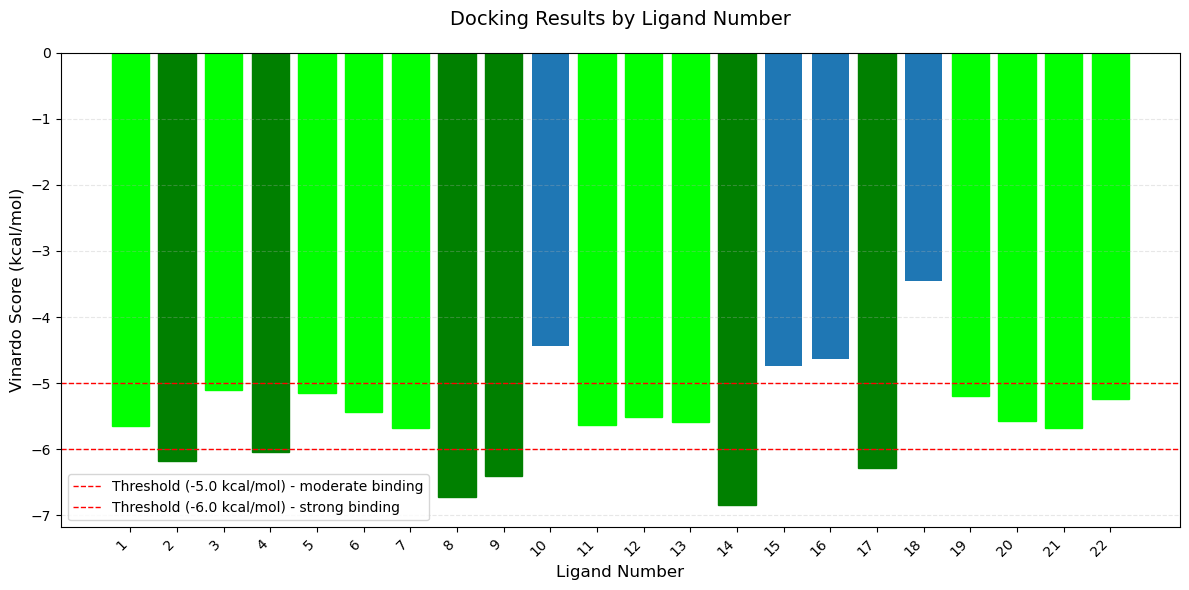

In [ ]:
df = pd.read_csv("vinardo_scores.csv")

df = df.sort_values("ligand_number")

plt.figure(figsize=(12, 6))
bars = plt.bar(df["ligand_number"].astype(str), 
               df["vinardo_score"],
               color='#1f77b4')

plt.axhline(y=-5.0, color='red', linestyle='--', linewidth=1, label='Threshold (-5.0 kcal/mol) - moderate binding')
plt.axhline(y=-6.0, color='red', linestyle='--', linewidth=1, label='Threshold (-6.0 kcal/mol) - strong binding')
plt.xlabel("Ligand Number", fontsize=12)
plt.ylabel("Vinardo Score (kcal/mol)", fontsize=12)
plt.title("Docking Results by Ligand Number", fontsize=14, pad=20)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()

# Highlight strong binder
for i, row in df.iterrows():
    if row['vinardo_score'] <= -5.0:
        bars[i].set_color('lime')  # Lime for moderate binders
    if row['vinardo_score'] <= -6.0:
        bars[i].set_color('green')  # Green for strong binders

plt.tight_layout()
plt.show()